In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import sys
import os
notebook_dir = os.path.abspath('')

# Get the parent directory (which should contain both 'notebooks' and 'shapes')
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now try to import
from shape_generator import draw_random_shape
from augmentations import random_augment,add_high_frequency_noise
from data_loaders import get_shape_loaders
from model import ResNet18, LinearProbe
import torch
import torch.nn as nn
import umap

from sklearn.metrics import accuracy_score



In [25]:
def evaluate_model(test_loader, model, device):
    stored_labels = []
    stored_outputs = []

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Get intermediate and final outputs from the model
            intermediate, outputs = model(images)
            
            # Apply linear probe to intermediate outputs to get predictions
            
            # Move data back to CPU and convert to numpy arrays
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            # Store results in lists
            stored_labels.append(labels)
            stored_outputs.append(outputs)

    # Concatenate stored results
    stored_labels = np.concatenate(stored_labels)
    stored_outputs = np.concatenate(stored_outputs)
    
    # Calculate accuracy of the predictions
    accuracy = accuracy_score(stored_labels, stored_outputs.argmax(axis=1))
    model.train()
    return  accuracy


In [26]:
shapes = ['circle','ellipse','triangle','square','rectangle',]


In [27]:
model = ResNet18(num_classes=5)
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#intermediate
n_probes = 3
linear_probes=[]
optimizers=[]
criteria = []
groups = [[0,1],[2],[3,4]]
for p in np.arange(n_probes):
    linear_probe = LinearProbe(input_dim=10, output_dim=1) 
    linear_probe = linear_probe.to(device)
    inter_optimizer = torch.optim.Adam(linear_probe.parameters(), lr=0.001)
    optimizers.append(inter_optimizer)
    criteria.append(nn.BCEWithLogitsLoss())
    linear_probes.append(linear_probe)
    

In [34]:
n_trains = [100,200,500,1000,2000]
num_epochs = 30
accuracies = np.zeros((len(n_trains),2))
stored_accuracies = np.zeros((len(n_trains),num_epochs,2))
for n_train in n_trains:
    #set up models and losses
    print(n_train)
    model = ResNet18(num_classes=5)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    train_loader, test_loader = get_shape_loaders(num_train=n_train, num_test=500, batch_size=64)
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            intermediate, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #intermediate predict
        

            # Backward pass and optimize
        #print(np.corrcoef(size.cpu().detach().numpy(),inter_outputs.cpu().detach().numpy().flatten())[0,1])
        accuracy = evaluate_model(test_loader, model, device)
        print(accuracy)
        stored_accuracies[n_trains.index(n_train),epoch,0] = accuracy
 

100
0.232
0.188
0.192
0.194
0.192
0.204
0.198
0.19
0.208
0.31
0.318
0.3
0.286
0.262
0.306
0.22
0.188
0.17
0.186
0.192
0.232
0.314
0.272
0.314
0.384
0.334
0.474
0.574
0.25
0.314
200
0.206
0.284
0.288
0.284
0.28
0.298
0.24
0.226
0.266
0.274
0.346
0.364
0.426
0.462
0.45
0.444
0.222
0.454
0.394
0.532
0.614
0.27
0.322
0.416
0.288
0.29
0.246
0.502
0.222
0.23
500
0.262
0.228
0.23
0.202
0.336
0.34
0.502
0.476
0.504
0.452
0.434
0.35
0.528
0.474
0.41
0.694
0.666
0.68
0.746
0.636
0.624
0.696
0.646
0.608
0.554
0.638
0.558
0.536
0.69
0.756
1000
0.124
0.284
0.408
0.696
0.388
0.29
0.412
0.262
0.318
0.378
0.532
0.18
0.706
0.232
0.832
0.514
0.31
0.804
0.78
0.234
0.188
0.838
0.708
0.816
0.208
0.846
0.214
0.442
0.552
0.378
2000
0.268
0.678
0.562
0.52
0.742
0.65
0.802
0.816
0.83
0.838
0.718
0.856
0.438
0.808
0.886
0.838
0.846
0.864
0.858
0.852
0.86
0.758
0.884
0.904
0.91
0.912
0.868
0.724
0.876
0.888


In [35]:
for n_train in n_trains:
    print(n_train)
    train_loader, test_loader = get_shape_loaders(num_train=n_train, num_test=500, batch_size=64)
    #set up models and losses
    print(n_train)
    model = ResNet18(num_classes=5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    n_probes = 3
    linear_probes=[]
    optimizers=[]
    criteria = []
    groups = [[0,1],[2],[3,4]]
    for p in np.arange(n_probes):
        linear_probe = LinearProbe(input_dim=10, output_dim=1) 
        linear_probe = linear_probe.to(device)
        inter_optimizer = torch.optim.Adam(linear_probe.parameters(), lr=0.001)
        optimizers.append(inter_optimizer)
        criteria.append(nn.BCEWithLogitsLoss())
        linear_probes.append(linear_probe)
        
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            intermediate, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            optimizer.step()
            #intermediate predict
            intermediate = intermediate.detach()
            for p in np.arange(n_probes):
                optimizers[p].zero_grad()
                
                inter_outputs = linear_probes[p](intermediate)
                inter_labels = torch.tensor([i in groups[p] for i in labels],dtype=torch.float32).to(device)
                inter_labels = inter_labels.unsqueeze(1)
                inter_loss = criteria[p](inter_outputs, inter_labels)
                inter_loss.backward(retain_graph=True)
                optimizers[p].step()
            

            # Backward pass and optimize
        #print(np.corrcoef(size.cpu().detach().numpy(),inter_outputs.cpu().detach().numpy().flatten())[0,1])
        accuracy = evaluate_model(test_loader, model, device)
        stored_accuracies[n_trains.index(n_train),epoch,1] = accuracy

100
100
200
200
500
500
1000
1000
2000
2000


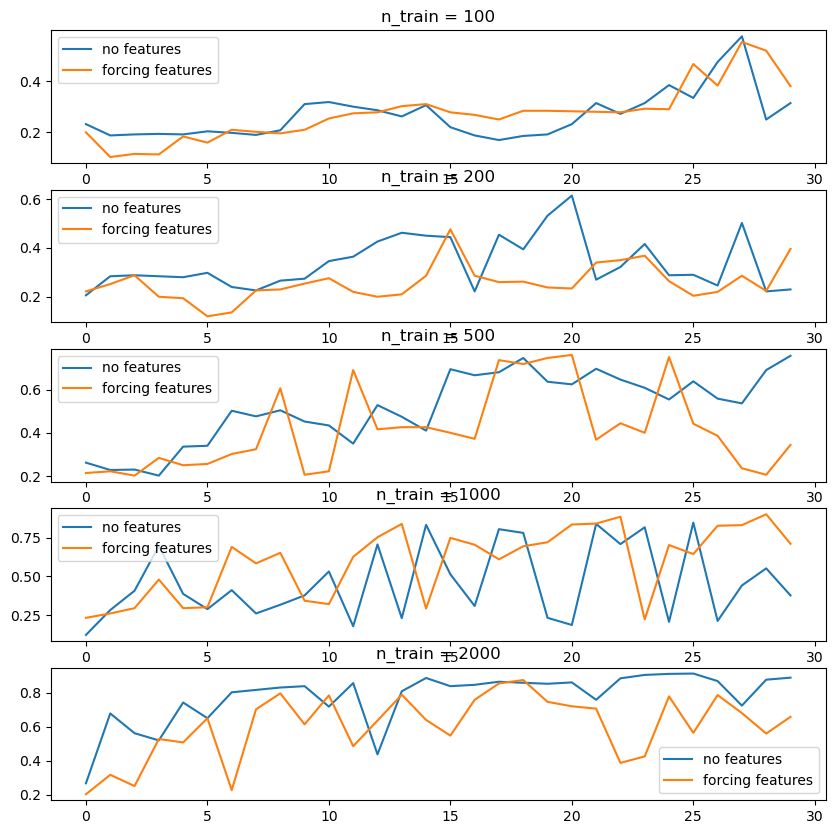

In [41]:
fig,axes = plt.subplots(len(n_trains),figsize=(10,10))
for i in np.arange(len(n_trains)):
    axes[i].plot(stored_accuracies[i,:,0], label='no features')
    axes[i].plot(stored_accuracies[i,:,1], label='forcing features')
    axes[i].set_title('n_train = {}'.format(n_trains[i]))
    axes[i].legend()